# Простой анализ паблика Newочём
 
В этом простеньком исследовании будет обсуждаться паблик [Newочём](https://vk.com/newochem), в котором пользователи в регулярном голосовании выбирают, какую англоязычную актуальную статью они бы хотели прочитать в переводе, а редакторы и переводчики сообщества ее переводят.

Я постараюсь собрать данные со всех голосований и проверить свою гипотезу о том, что 
> при достаточно длинном описании всех вариантов голосования многие участники не могут прочитать все варианты внимательно,
> или их внимание убывает от первого варианта к последнему и по этой причине они чаще всего выбирают первый вариант, который в итоге побеждает

Эту гипотезу и ее анализ не стоит воспринимать слишком серьезно - для корректной ее проверки необходимо проводить дополнительные эксперименты. Гипотеза возникла из-за моего постоянного участия в голосовании и от удивления, что так часто побеждает первый вариант. 

Также будет проведен анализ того, какие источники статей более ценимы сообществом и существуют ли слова, при наличии которых участники более охотно голосуют за вариант.

Все исследование на python.

In [1]:
import requests as rq
import datetime as dt
import time
import json
import pandas as pd
import pymorphy2
import pylab as plt
import numpy as np

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
#следует ли по новой выгружать данные - минут 10 это занимает
download_data = False

In [3]:
foundation = dt.datetime.strptime('16 11 2014', '%d %m %Y') #дата основания паблика

Для загрузки постов используется один единственный метод VK API - а именно wall.get:
https://new.vk.com/dev/wall.get

In [4]:
response = rq.get('https://api.vk.com/method/wall.get?', params={'owner_id' : '-80512191', 'filter' : 'owner', 
                                                                 'count' : 10, 'offset' : 0, 'v' : '5.52'})
response

<Response [200]>

In [5]:
def download_newochem_data():
    raw_data = []
    skip = 0
    chunksize = 10
    date = dt.datetime.now()
    while date > foundation:
        response = rq.get('https://api.vk.com/method/wall.get?', params={'owner_id' : '-80512191', 'filter' : 'owner', 
                                                                     'count' : chunksize, 'offset' : skip, 'v' : '5.52'})
        if response.ok and response.json()['response']['items']:
            date = dt.datetime.fromtimestamp(response.json()['response']['items'][-1]['date'])
            raw_data.append(response.json())
        else:
            break
        time.sleep(4)
        skip += chunksize
    return raw_data

In [6]:
%%time

if download_data:
    raw_data = download_newochem_data()

Wall time: 8min 38s


In [10]:
#парсим наши данные и сохраняем их на диск
if download_data:
    items = []
    for entry in raw_data:
        for item in entry['response']['items']:
            items.append(item)
    with open('data.json', 'w') as outfile:
        data = {'items':items}
        json.dump(data, outfile)

In [11]:
#или достаем с диска
if not download_data:
    with open('data.json', 'r') as fp:
        data = json.load(fp)

In [13]:
print 'Всего загружено на стене постов: ', len(data['items'])

Всего загружено на стене постов:  1206


In [14]:
#находим среди этих постов только голосования
polls = []
for item in data['items']:
    date = dt.datetime.fromtimestamp(item['date'])
    if 'attachments' in item.keys():
        for attach in item['attachments']:
            if attach['type'] == 'poll':
                polls.append((date, attach, item))

In [15]:
print 'Всего проведено голосований: ', len(polls)

Всего проведено голосований:  395


Все, данные извлечены, теперь можно с ними работать. В качестве затравки можно посмотреть, как росло количество участников в опросах с начала основания группы:

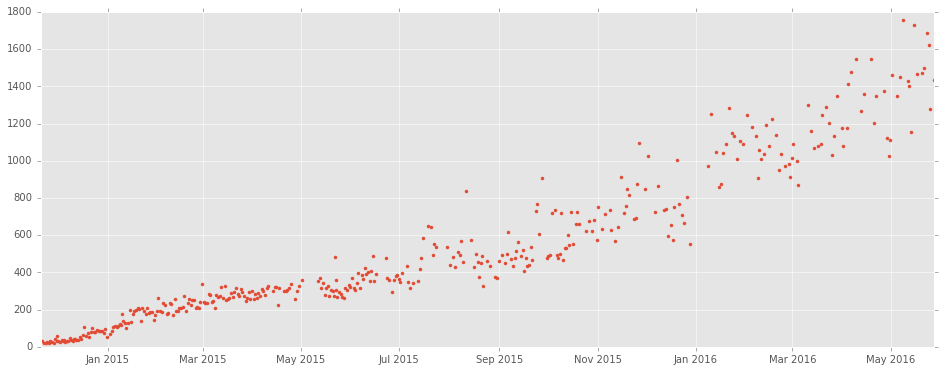

In [16]:
votes = []

for (date, p, _) in polls:
    poll = p['poll']
    votes.append((date, int(poll['votes'])))
    
fig = plt.figure(figsize = [16, 6])
xx, yy = zip(*votes)
plt.plot(xx, yy, '.')
plt.show()

Видно здоровый растущий тренд, но также и монолитность теряется - больше становится разброс.

Чтобы проводить весь дальнейший анализ было удобно и ненакладно проверять новые идеи - создадим DataFrame со всеми необходимыми данными.

In [17]:
df = pd.DataFrame(polls, columns=['date', 'poll', 'item'])

In [18]:
df[0:3]

,date,poll,item
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...


In [19]:
#добавим количество голосовавших и число вариантов ответа
df['votes'] = df['poll'].apply(lambda l: int(l['poll']['votes']))
df['opts'] = df['poll'].apply(lambda l: len(l['poll']['answers']))

In [20]:
df[0:3]

,date,poll,item,votes,opts
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...,1433,5
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...,1281,5
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...,1622,5


In [21]:
print 'Опросов не с 5 вариантами ответа: ', len(df[df['opts'] != 5]), '(т.е. примерно 1/8 от общего числа)'

Опросов не с 5 вариантами ответа:  46 (т.е. примерно 1/8 от общего числа)


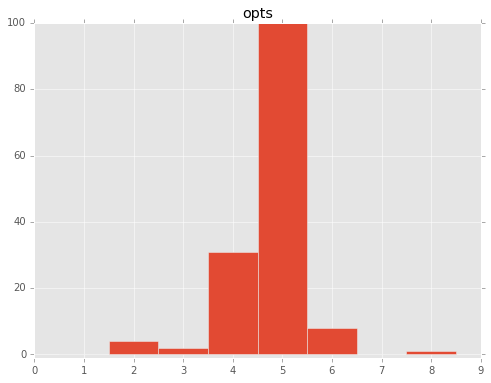

In [22]:
df.hist(column='opts', figsize = [8, 6], bins=np.arange(1,10)-0.5)
plt.xlim(0, 9)
plt.ylim(-1, 100)
plt.show()

Видно, что есть много опросов с 4 вариантами и какая-то мелочь с 2,3,6 и даже один опрос с 8 вариантами. 

In [23]:
print 'Всего голосовало за все время: ', df['votes'].sum()

Всего голосовало за все время:  201595


In [24]:
#добавляем текст от поста с голосованием 
df['text'] = df['item'].apply(lambda l: l['text'])

In [25]:
def get_rates_vector(p):
    rates_v = []
    for ind, opt in enumerate(p['poll']['answers']):
        rates_v.append((opt['rate'], ind+1))
    return rates_v

#добавляем результаты опроса, отсортированные в убывающем порядке, нумерация с 1
df['rates'] = df['poll'].apply(get_rates_vector)
df['rates'] = df['rates'].apply(sorted, reverse=True)

In [26]:
df[0:3]

,date,poll,item,votes,opts,text,rates
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...,1433,5,Переводим №2\n\n1. [id1719186|Александр Марчук...,"[(34.47, 2), (27.91, 1), (15.91, 3), (12.35, 4..."
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...,1281,5,UPD: Переводим №3. \n\n1. [id44532401|Иван Чер...,"[(26.15, 3), (22.4, 1), (19.67, 4), (17.95, 2)..."
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...,1622,5,UPD: Переводим №1. \n\n1. Slate внезапно выясн...,"[(23.67, 1), (22.87, 4), (22.32, 5), (19.73, 2..."


Теперь попробуем распарсить текст поста и достать описание к каждому варианту и ссылку на первоисточник. Сделать это можно не всегда - раньше описание и ссылки были внутри картинок, но таких случаев (назовем их "ленивыми", потому что их можно было бы достать, потратив больше времени) будет не очень много:

In [27]:
def get_opts_description(poll):
    descr = None
    if poll['text'] and poll['text'].count('http') > 3:
        descr = []
        text = poll['text']
        parts = text.split('http')
        links = []
        description = parts[0][:-3]
        for ind, part in enumerate(parts[1:]):
            link = part.split('\n')[0]
            descr.append((ind+1, description, u'http' + link))
            description = part[len(link):-3]        
    if descr:
        descr = [x for x in descr if x[1]]
        descr = zip(range(len(descr)), zip(*descr)[1], zip(*descr)[2])
    return descr

In [28]:
df['descriptions'] = df['item'].apply(get_opts_description)

In [29]:
df[0:3]

,date,poll,item,votes,opts,text,rates,descriptions
0,2016-05-27 12:30:56,"{u'poll': {u'votes': 1433, u'created': 1464334...",{u'attachments': [{u'photo': {u'photo_130': u'...,1433,5,Переводим №2\n\n1. [id1719186|Александр Марчук...,"[(34.47, 2), (27.91, 1), (15.91, 3), (12.35, 4...","[(0, Переводим №2\n\n1. [id1719186|Александр М..."
1,2016-05-25 14:07:12,"{u'poll': {u'votes': 1281, u'created': 1464174...",{u'attachments': [{u'photo': {u'photo_130': u'...,1281,5,UPD: Переводим №3. \n\n1. [id44532401|Иван Чер...,"[(26.15, 3), (22.4, 1), (19.67, 4), (17.95, 2)...","[(0, UPD: Переводим №3. \n\n1. [id44532401|Ива..."
2,2016-05-24 13:35:38,"{u'poll': {u'votes': 1622, u'created': 1464086...",{u'attachments': [{u'photo': {u'photo_130': u'...,1622,5,UPD: Переводим №1. \n\n1. Slate внезапно выясн...,"[(23.67, 1), (22.87, 4), (22.32, 5), (19.73, 2...","[(0, UPD: Переводим №1. \n\n1. Slate внезапно ..."


In [30]:
print 'Ленивых случаев без описания и ссылок: ', df['descriptions'].isnull().sum()

Ленивых случаев без описания и ссылок:  19


Все, вседанные собраны, посмотрим теперь, какие сайты выше ценятся среди участников. Ценность будет определять просто - как сумму голосов, отданную за тот или иной вариант или как среднюю сумму голосов за статьи на сайте:

In [31]:
from urlparse import urlparse
voted_links = {}
count_links = {}

for ind, row in df.iterrows():
    for rate in row['rates']:
        if row['descriptions'] and rate[1] < len(row['descriptions']):
            link = urlparse(row['descriptions'][rate[1]-1][2]).netloc
            if link in voted_links.keys():
                voted_links[link] += rate[0]*row['votes']/100.
                count_links[link] += 1
            else:
                voted_links[link] = rate[0]*row['votes']/100.
                count_links[link] = 1

In [32]:
voted_links_sorted = sorted([(voted_links[l], l) for l in voted_links.keys()], reverse=True)
mean_voted_links_sorted = sorted([(voted_links[l]/count_links[l], l) for l in voted_links.keys()], reverse=True)

In [33]:
print 'Различных источников статей: ', len(voted_links_sorted)

Различных источников статей:  123


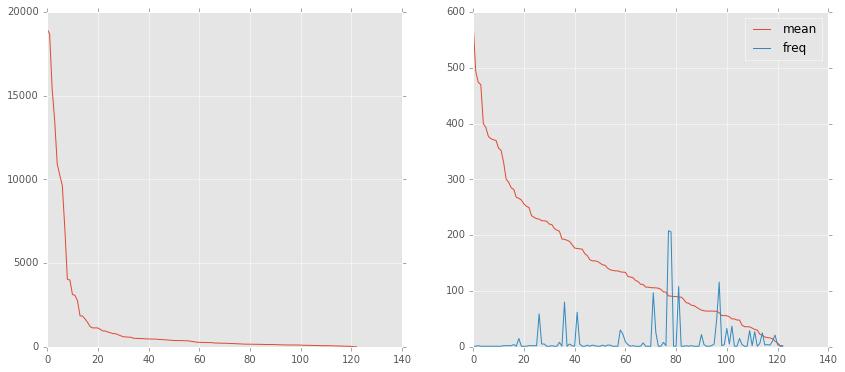

In [34]:
N = len(voted_links_sorted)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=[14, 6])
ax1.plot(range(N), zip(*voted_links_sorted[0:N])[0], '-')
ax2.plot(range(N), zip(*mean_voted_links_sorted[0:N])[0], '-', label='mean')
ax2.plot(range(N), map(lambda l: count_links[l], zip(*mean_voted_links_sorted[0:N])[1]), '-', label='freq')
ax2.legend()
plt.show()

Видно, что в случае с суммарной оценкой около 20 источников поставляют подавляющее количество статей. Если считать среднюю оценку, то распределение гораздо более плавное - но оценку больше половины демонстрируют тоже около 20 источников, причем если смотреть на частоты - то это просто статьи, которые один раз попали в выборку и были хорошо приняты (тогда как большие агрегаторы, например Wired, часто попадают в выборку и усредняются). Посмотрим на топ сайтов для обоих случаев: 

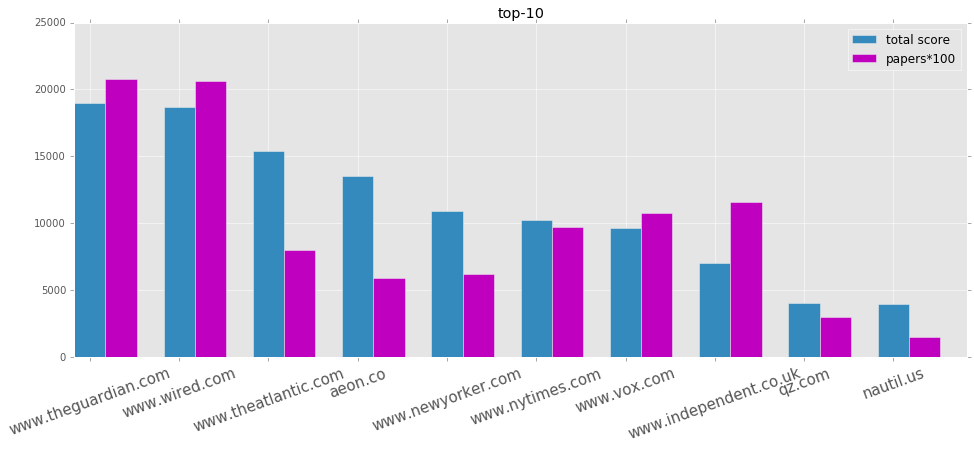

In [35]:
fig = plt.figure(figsize=[16,6])

bar_width = 0.35

plt.bar(np.arange(10), zip(*voted_links_sorted[0:10])[0],  bar_width, label='total score')
plt.bar(np.arange(10)+bar_width, map(lambda l: 100*count_links[l], zip(*voted_links_sorted[0:10])[1]), 
        bar_width, color='m', label='papers*100')

plt.xticks(np.arange(10)+bar_width/2, zip(*voted_links_sorted[0:10])[1], rotation=20., fontsize=15)
plt.title('top-10')
plt.legend()
plt.show()

Для каждого источника показана оценка и число статей в выборке, умноженное на 100. Видно, что The Guardian и Wired вырвались за счет количества статей, а вот The Atlantic и Aeon - скорее качества. Посмотрим остальные 10:

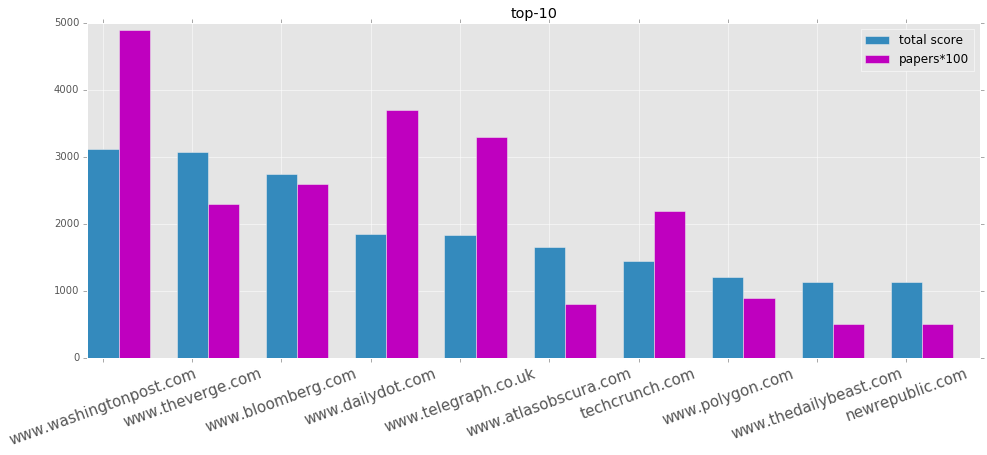

In [36]:
fig = plt.figure(figsize=[16,6])
plt.bar(np.arange(10), zip(*voted_links_sorted[10:20])[0],  bar_width, label='total score')
plt.bar(np.arange(10)+bar_width, map(lambda l: 100*count_links[l], zip(*voted_links_sorted[10:20])[1]), 
        bar_width, color='m', label='papers*100')

plt.xticks(np.arange(10)+bar_width/2, zip(*voted_links_sorted[10:20])[1], rotation=20., fontsize=15)
plt.title('top-10')
plt.legend()
plt.show()

Ничего необычного. Посмотрим теперь на рекордсменов по среднему весу статьи:

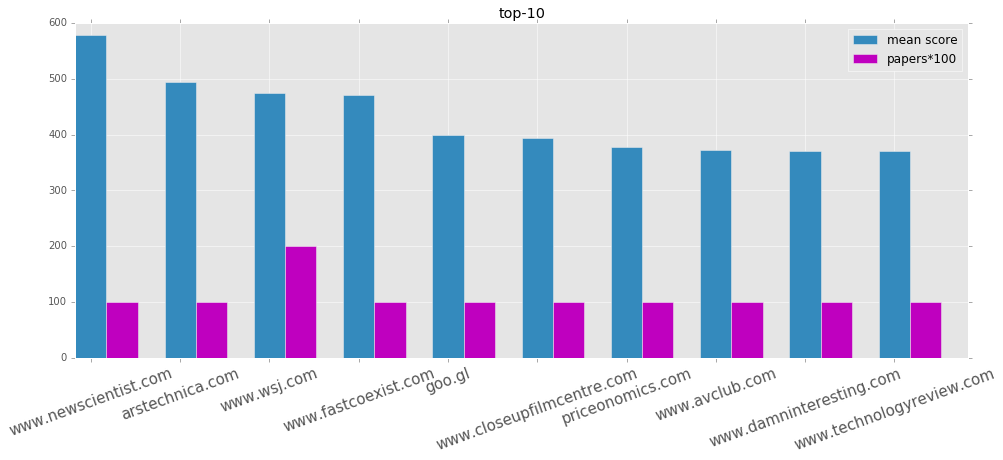

In [47]:
fig = plt.figure(figsize=[16,6])

bar_width = 0.35

plt.bar(np.arange(10), zip(*mean_voted_links_sorted[0:10])[0],  bar_width, label='mean score')
plt.bar(np.arange(10)+bar_width, map(lambda l: 100*count_links[l], zip(*mean_voted_links_sorted[0:10])[1]), 
        bar_width, color='m', label='papers*100')

plt.xticks(np.arange(10)+bar_width/2, zip(*mean_voted_links_sorted[0:10])[1], rotation=20., fontsize=15)
plt.title('top-10')
plt.legend()
plt.show()

Видно, что все эти сайты, за одним исключением, опубликовали одну хорошую статью, которая попала в выборку и за нее активно голосовали (кроме wsj - те опубликовали аж две хорошие статьи).

Вот эти статьи списком:

* cтатья про женщину, что слышит человека прежде, чем тот говорит на [newscientist.com](https://www.newscientist.com/article/dn23813-mindscapes-first-man-to-hear-people-before-they-speak?full=true#.UdblPz5AS6d)

* совсем свежее про устройство интернета от [arstechnica](http://arstechnica.com/information-technology/2016/05/how-the-internet-works-submarine-cables-data-centres-last-mile/)

* две статьи от wsj: [раз](http://www.wsj.com/articles/why-the-west-and-the-rest-got-rich-1463754427?utm_source=pocket&utm_medium=email&utm_campaign=pockethits) - про обогащение запада и [два](http://www.wsj.com/ad/cocainenomics)  - про медельинский наркокартель

* критика капитализма от [fastcoexist](http://www.fastcoexist.com/3056483/welcome-to-the-post-work-economy)

* материал на [aeon](https://goo.gl/gh9iyT), который вставили сокращателем ссылок и который не должен быть в этом списке, об индийском ученом по фамилии Двали и его открытии

* речь о кино в [closeupfilmcentre](https://www.closeupfilmcentre.com/vertigo_magazine/volume-3-issue-3-autumn-2006/a-letter-to-a-boy-from-his-mother/) про то, что снилось людям в те времена, когда кино ещё не изобрели

* финансовая пирамида ККК от [priceonomics](http://priceonomics.com/when-the-kkk-was-a-pyramid-scheme/)

* злодеи-американцы в советском кино от [avclub](http://www.avclub.com/article/villain-gap-why-soviet-movies-rarely-had-american--234481)

* лонгрид о высокотехнологичном ограблении от [damninteresting](http://www.damninteresting.com/the-zero-armed-bandit/)

* [technologyreview](https://www.technologyreview.com/s/601417/the-unbelievable-reality-of-the-impossible-hyperloop/) рассказывает про Hyperloop (ха, это я прислал)

* ну и раз затесался левый aeon - то следующий по списку на 11ом месте лонгрид про крионику в блоге [waitbutwhy](http://waitbutwhy.com/2016/03/cryonics.html) (это наверное лучшее, что я читал)

#### Настала очередь пытаться проверить описанную в начале гипотезу. 
Для ее проверки сначала поймем, как часто вообще выигрывает какой из вариантов:

In [38]:
opt1, opt2, opt3, opt4, opt5 = [],[],[],[],[]
dates = [] 
for (date, p, _) in polls:
    poll = p['poll']
    #берем опросы только длины 5, которых примерно 350 штук
    if len(poll['answers']) == 5:
        answers = poll['answers']
        opt1.append(answers[0]['rate'])
        opt2.append(answers[1]['rate'])
        opt3.append(answers[2]['rate'])
        opt4.append(answers[3]['rate'])
        opt5.append(answers[4]['rate'])
        dates.append(date)

Сравнивать будем проценты. Для начала посмотрим на boxplot:

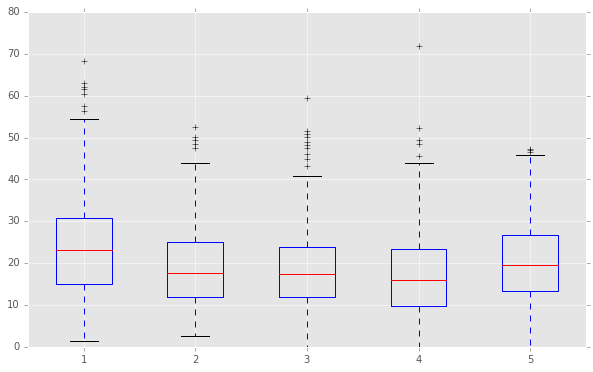

In [39]:
fig = plt.figure(figsize=[10,6])
plt.boxplot([opt1,opt2,opt3,opt4,opt5])
plt.show()

Видно, что медиана с 75% квантиль для первого варианта выше, чем для остальных. Т.е. сами данные похожи на то, что за первый вариант голосуют сильно чаще, хотя пока не ясно, насколько это значимо. Вид распределения у всех вариантов достаточно близок друг к другу, особенно варианты 2-4 (что может свидетельствовать о верности немного измененной гипотезы: побеждают чаще крайние варианты). 

Это было распределение по процентам, посмотрим, как часто выигрывает какой из вариантов:

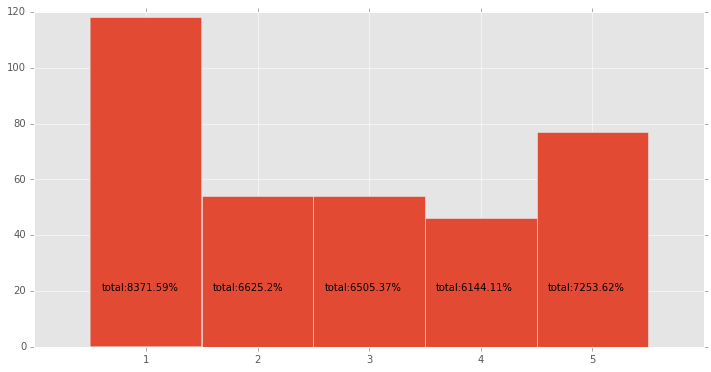

In [40]:
opts = zip(opt1, opt2, opt3, opt4, opt5)
best = []
for o in opts:
    best.append(o.index(max(o))+1)
    
fig = plt.figure(figsize=[12,6])
count_best, _, _ = plt.hist(best, bins=np.arange(1,7)-0.5)
plt.xticks(range(1,6))
for i in range(5):
    plt.text(i+0.6, 20., 'total:{}%'.format(sum([opt1, opt2, opt3, opt4, opt5][i])))
plt.show()

Т.е. более чем в $\frac{1}{3}$ голосований побеждает первый вариант, что опять же очень подозрительно. Попробуем еще посмотреть ранг каждого варианта (ранг - это сумма мест в голосовании):

In [41]:
best_rank = [0,0,0,0,0]
for o in opts:
    q = zip(o, range(1,6))
    q = sorted(q)
    for i in range(5):
        best_rank[q[i][1]-1] += 5-i
best_rank

[897, 1100, 1088, 1160, 990]

Опять же видно, что ранг первого варианта меньше остальных, т.е. первый ответ в голосовании реже других оказывается на последних местах.

Давайте попробуем оценить, насколько значимо статистически наше распределение отличается от ситуации, когда все варинаты одинаково часто оказываются на первом месте - для чего применим критерий $\chi^2$:

In [42]:
from scipy import stats
chis,pvalue = stats.chisquare(count_best, f_exp = [sum(count_best)/5.]*5)
pvalue, chis

(5.0669298134213526e-10, 49.295128939828082)

Т.е. $\chi^2$-критерий еще раз подтверждает то, что видно выше - ситуация значимо отличается от равномерной.

In [53]:
morph = pymorphy2.MorphAnalyzer()

In [54]:
import unicodedata
import sys


tbl = dict.fromkeys(i for i in xrange(sys.maxunicode)
                      if unicodedata.category(unichr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl)

In [57]:
%%time

wwords = {}
big_bag = {}
# good_pos = ['NOUN', 'ADJF', 'ADJS', 'VERB', 'INFN', 'PRTF', 'PRTS']
good_pos = ['NOUN']
variants = {}
words_sum = 0

for index, row in df.iterrows():
    if row['descriptions']:
#         print index, len(row['descriptions']), len(row['poll']['poll']['answers'])
        answers = row['poll']['poll']['answers']
        for (ind, descr, link_) in row['descriptions'][0:len(answers)]:
        #         print row['poll']['poll']['answers'][ind-1]['text']
            text = descr + answers[ind-1]['text']
            bag = remove_punctuation(text).replace('\n', '').split(' ')
            words_sum += len(bag)
            votes = int(answers[ind]['votes'])
#             print ind, votes
            part_of_speech_only = []
            for word in bag:
                if len(word) > 2:
                    for form in morph.parse(word):
                        part_of_speech_only.append((form.normal_form, form.tag.POS, word))
            forms = part_of_speech_only
            for form in set(forms):
                key = None
                if not form[1]:
                    key = form[0] + ', NONE'
                if form[1] and form[1] in good_pos:
                    key = form[0] + ', ' + form[1]
                if key:
                    if key in wwords.keys():
                        wwords[key] += votes
                    else:
                        wwords[key] = votes
                    
                    if key in variants.keys():
                        variants[key].append(form[2])
                    else:
                        variants[key] = [form[2]]

                    if key in big_bag.keys():
                        big_bag[key] += 1
#                         big_bag[key] += forms.count(form)
#                         if key == u'порно, NOUN':
#                             print index, ind, forms.count(form)
                    else:
                        big_bag[key] = 1
#                         big_bag[key] = forms.count(form)

Wall time: 27.3 s


In [58]:
len(wwords)

7536

In [59]:
wwords_list = [[wwords[key], key] for key in wwords.keys()]
wwords_list = sorted(wwords_list, reverse=True)

In [ ]:
from wordcloud import WordCloud

wc_text = ''
for (weight, w) in wwords_list[2:300]:
    wc_text += (' '+w[:w.index(',')])*int(weight)

fig = plt.figure(figsize=(10, 12))
wordcloud = WordCloud(background_color='black',
                          width=1200,
                          height=1000).generate(wc_text)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [64]:
for (weight, w) in wwords_list[0:60]:
    print u'{:20s} {}\t {}'.format(w, wwords[w], big_bag[w])

человек, NOUN        59982	 438
the, NONE            57610	 381
том, NOUN            51445	 436
тома, NOUN           51119	 434
статья, NOUN         45167	 318
материал, NOUN       32811	 217
история, NOUN        30121	 195
лонгрид, NOUN        28574	 183
год, NOUN            27217	 222
лонгрида, NOUN       27175	 177
new, NONE            27065	 205
atlantic, NONE       24261	 127
wired, NONE          22252	 221
жизнь, NOUN          19833	 141
миро, NOUN           18690	 150
мир, NOUN            18690	 150
guardian, NONE       17214	 171
стать, NOUN          16654	 115
подборка, NOUN       15551	 107
times, NONE          15098	 133
upd, NONE            14366	 46
текст, NOUN          14029	 60
york, NONE           13885	 126
vox, NONE            13854	 149
вопрос, NOUN         12816	 93
эссе, NOUN           12624	 59
автор, NOUN          12419	 68
спасибо, NOUN        12368	 63
yorker, NONE         12241	 71
конец, NOUN          12234	 93
aeon, NONE           11974	 56
сша, NOUN        

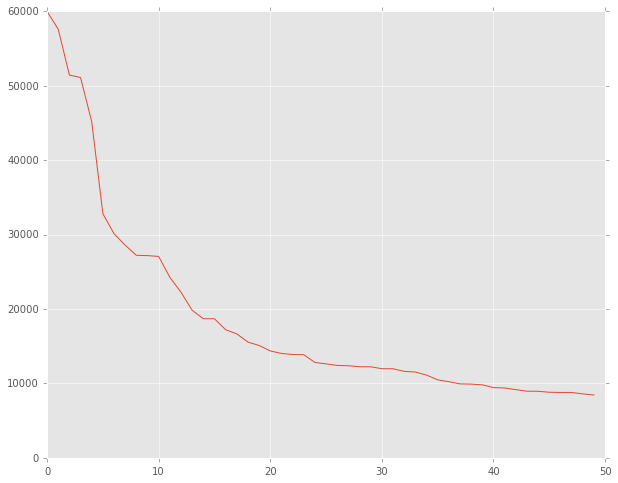

In [62]:
fiig = plt.figure(figsize=[10,8])
plt.plot(range(50), zip(*wwords_list)[0][0:50], '-')
# plt.grid()
plt.show()

In [65]:
words_of_interest = [u'секс, NOUN', u'порно, NOUN',  u'девайс, NOUN',  u'маска, NOUN',  u'технология, NOUN',  
                     u'политика, NOUN', u'запад, NOUN',  u'учёный, NOUN',  u'исследование, NOUN',  u'история, NOUN',
                     u'россия, NOUN', u'будущее, NOUN', u'труп, NOUN']

In [66]:
for p in variants[u'илона, NOUN']:
    print p

Илона
Илона
Илона
Илон
Илона


In [97]:
for word in words_of_interest:
    print u'{:20s} {}\t {}\t {:.0f}'.format(word, wwords[word], big_bag[word], wwords[word]/float(big_bag[word]))

секс, NOUN           1372	 5	 274
порно, NOUN          1475	 11	 134
девайс, NOUN         1706	 8	 213
маска, NOUN          1865	 9	 207
технология, NOUN     5078	 30	 169
политика, NOUN       5099	 36	 142
запад, NOUN          4848	 37	 131
учёный, NOUN         9809	 70	 140
исследование, NOUN   4496	 29	 155
история, NOUN        30121	 195	 154
россия, NOUN         9434	 81	 116
будущее, NOUN        8589	 56	 153


In [98]:
wwords_list = [[wwords[key]/float(big_bag[key]), key] for key in wwords.keys()]
wwords_list = sorted(wwords_list, reverse=True)

In [99]:
for (weight, w) in wwords_list[0:60]:
    print u'{:25s} {}\t {}'.format(w, weight, big_bag[w])

первуюв, NOUN             834.0	 1
id2976692|anton, NONE     706.0	 2
angel, NONE               706.0	 2
хоффман, NOUN             691.0	 1
обусловлен2, NONE         691.0	 1
корн, NOUN                691.0	 1
№1вота, NOUN              677.0	 1
фейк5, NONE               677.0	 1
иллинойс, NOUN            677.0	 1
№1в, NONE                 645.0	 1
институт, NOUN            645.0	 1
воспоминания5, NONE       645.0	 1
today, NONE               645.0	 1
psychology, NONE          645.0	 1
dêtre, NONE               645.0	 1
экономику5, NONE          626.0	 1
переврала5, NONE          607.0	 1
говорить5, NONE           578.0	 1
сахар, NOUN               576.0	 1
питание, NOUN             576.0	 1
ошибались5, NONE          576.0	 1
жир, NOUN                 576.0	 1
1972, NONE                576.0	 1
филиппинка, NOUN          561.0	 1
систем4, NONE             561.0	 1
забота, NOUN              561.0	 1
обитания1, NONE           559.0	 1
фокус, NOUN               557.0	 1
самосуд, NOUN       

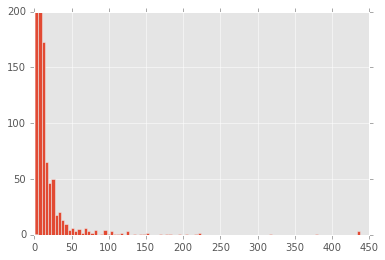

In [72]:
plt.hist(big_bag.values(), bins=100)
plt.ylim(0, 200)
plt.show()

In [73]:
def f(x):
    return (x-25)**2 + 1.

In [74]:
wwords_list = [[wwords[key]/f(big_bag[key]), key] for key in wwords.keys()]
wwords_list = sorted(wwords_list, reverse=True)

In [76]:
for (weight, w) in wwords_list[0:140]:
    if w.endswith(', NOUN') or w.endswith(', NONE'): 
        print u'{:20s} {}\t {}'.format(w, wwords[w], big_bag[w])

век, NOUN            4127	 25
verge, NONE          3874	 25
пример, NOUN         3693	 25
рассказ, NOUN        3463	 25
военный, NOUN        3292	 25
журнал, NOUN         2865	 25
колонок, NOUN        2623	 25
школа, NOUN          2437	 25
мозг, NOUN           4636	 26
веко, NOUN           4019	 24
университет, NOUN    3965	 24
закон, NOUN          3848	 26
количество, NOUN     3694	 24
идея, NOUN           3647	 26
отношение, NOUN      3593	 26
машин, NOUN          3161	 24
знать, NOUN          3075	 24
пот, NOUN            2985	 24
колонка, NOUN        2984	 26
вид, NOUN            2956	 26
дом, NOUN            2728	 26
факт, NOUN           2682	 24
сила, NOUN           2443	 24
наркотик, NOUN       2411	 24
неделя, NOUN         2373	 24
ситуация, NOUN       2198	 26
украина, NOUN        2075	 26
сми, NOUN            2024	 24
европа, NOUN         1949	 24
суд, NOUN            1912	 24
мужчина, NOUN        4297	 27
цру, NOUN            1634	 24
аналитик, NOUN       1608	 24
точка, NOU

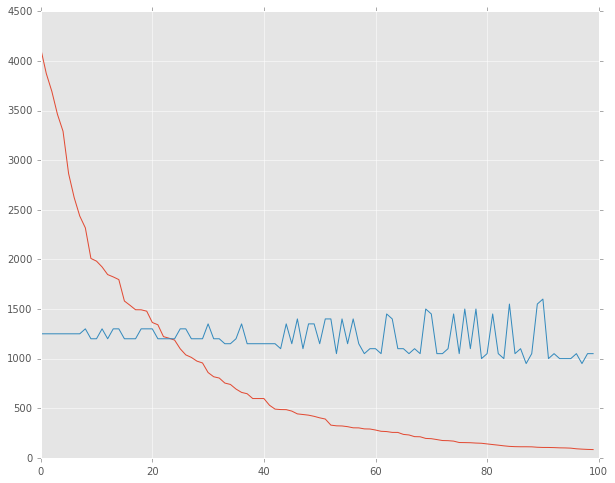

In [79]:
N = 100
fig = plt.figure(figsize=[10,8])
plt.plot(range(N), zip(*wwords_list)[0][0:N], '-')
plt.plot(range(N), map(lambda l: 50*big_bag[l], zip(*wwords_list)[1][0:N]), '-')
plt.show()

In [80]:
accum_weight = 0
accum_weights = []
for (weight, w) in wwords_list:
    accum_weight += weight
    accum_weights.append(accum_weight)

In [82]:
weight_sum = accum_weight
weight_sum

89986.3445742275

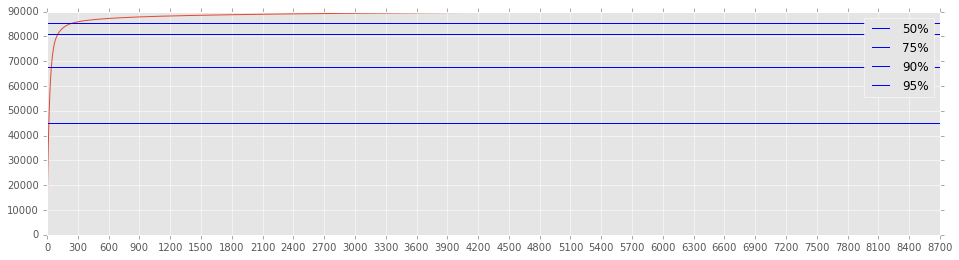

In [87]:
fig = plt.figure(figsize=[16,4])
plt.plot(range(len(wwords_list)), accum_weights, '-')
plt.axhline(y = weight_sum*0.50, label='50%')
plt.axhline(y = weight_sum*0.75, label='75%')
plt.axhline(y = weight_sum*0.90, label='90%')
plt.axhline(y = weight_sum*0.95, label='95%')
plt.legend()
plt.xticks(range(0, 9000, 300))
plt.show()

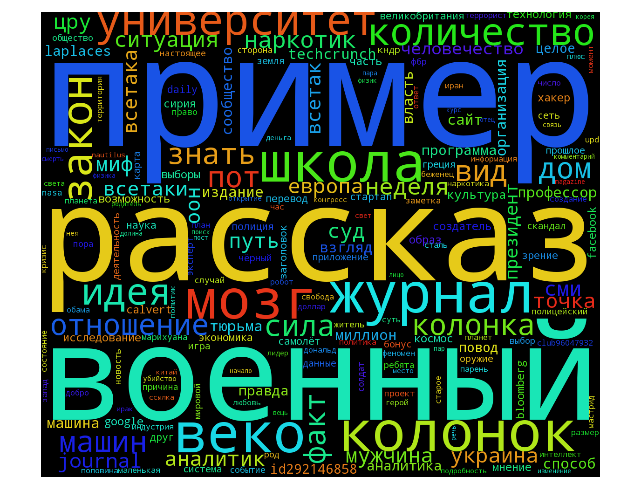

In [89]:
from wordcloud import WordCloud

wc_text = ''
for (weight, w) in wwords_list[2:300]:
    wc_text += (' '+w[:w.index(',')])*int(weight)

fig = plt.figure(figsize=(10, 12))
wordcloud = WordCloud(background_color='black',
                          width=1200,
                          height=1000).generate(wc_text)
img=plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [90]:
plausible_nouns = [w[1] for w in wwords_list[2:300]]

In [91]:
%%time
opts = [[],[],[],[],[],[],[],[]]

# wwords = {}
# big_bag = {}
# good_pos = ['NOUN', 'ADJF', 'ADJS', 'VERB', 'INFN', 'PRTF', 'PRTS']
# variants = {}
# words_sum = 0

for index, row in df.iterrows():
    if row['descriptions']:
#         print index, len(row['descriptions']), len(row['poll']['poll']['answers'])
        answers = row['poll']['poll']['answers']
        for (ind, descr, link_) in row['descriptions'][0:len(answers)]:
        #         print row['poll']['poll']['answers'][ind-1]['text']
            text = descr + answers[ind-1]['text']
            bag = remove_punctuation(text).replace('\n', '').split(' ')
            words_sum += len(bag)
            votes = int(option['votes'])
            part_of_speech_only = []
            for word in bag:
                if len(word) > 2:
                    for form in morph.parse(word):
                        part_of_speech_only.append((form.normal_form, form.tag.POS))
            forms = set(part_of_speech_only)
            weight = 0
            for form in forms:
                key = None
                if not form[1]:
                    key = form[0] + ', NONE'
                if form[1] and form[1] in good_pos:
                    key = form[0] + ', ' + form[1]
                if key and key in plausible_nouns:
#                     print key
                    weight += wwords[key]
            opts[ind].append(weight)

Wall time: 14.4 s


In [92]:
# opt1, opt2, opt3, opt4, opt5, opt6, opt7, opt8 = 
for opt in opts:
    print len(opt)
#     plt.boxplot(opt)
# plt.show()

376
376
376
376
350
7
0
0


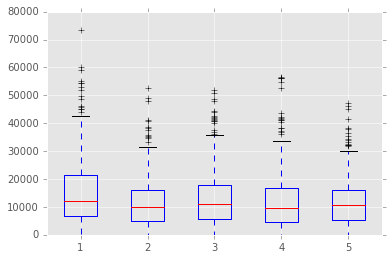

In [93]:
plt.boxplot(opts[0:5])
plt.show()